In [1]:
import tensorflow as tf

In [2]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


"""
# Fashion MNIST Classification with ResNet50

This notebook covers:
1. Data loading and exploration
2. Data visualization
3. Model building with HuggingFace ResNet50
4. Training and evaluation
5. Flask app creation for deployment
"""

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D, Dense, Reshape
from tensorflow.keras.models import Model
from transformers import TFResNetModel, ResNetConfig
from sklearn.metrics import confusion_matrix, classification_report
import os
import json
from PIL import Image
import io

c:\Users\wasif\AppData\Local\pypoetry\Cache\virtualenvs\fmnist-T3Y_rP-5-py3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



## 1. Data Loading and Exploration


In [2]:
# Load Fashion MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)
Number of classes: 10


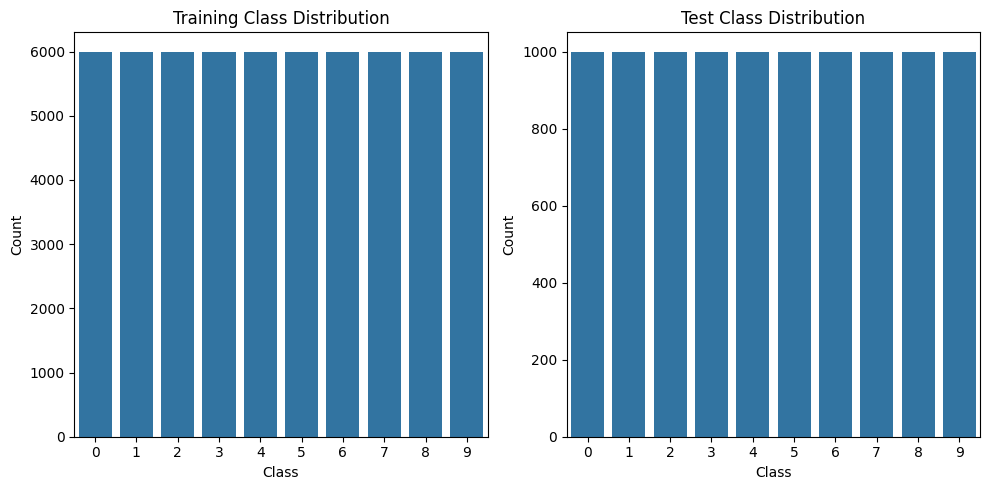

In [3]:
# Basic information about the dataset
print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)
print("Number of classes:", len(np.unique(y_train)))

# %%
# Display class distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Training Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x=y_test)
plt.title('Test Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 2. Data Visualization

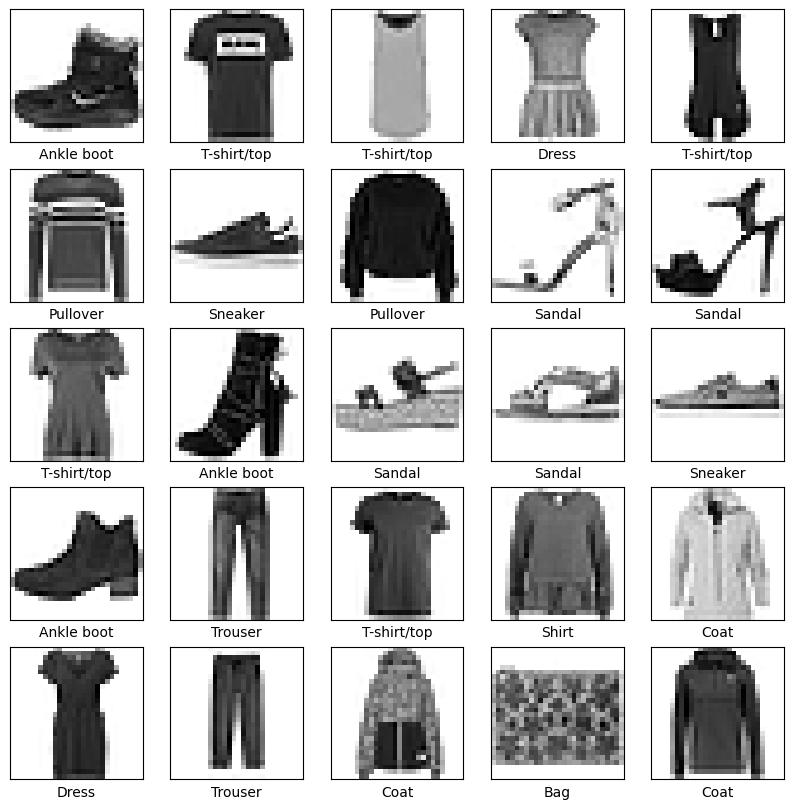

In [4]:
# Display sample images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

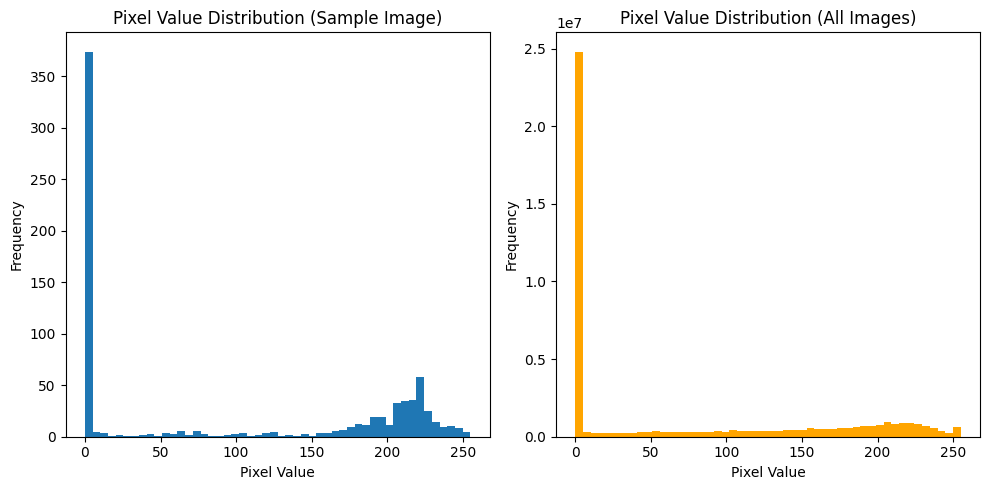

In [5]:
# Pixel value distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(x_train[0].flatten(), bins=50)
plt.title('Pixel Value Distribution (Sample Image)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(x_train.flatten(), bins=50, color='orange')
plt.title('Pixel Value Distribution (All Images)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


## 3. Data Preprocessing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07301454..0.90843457].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08019862..1.0547084].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.066664964..0.92985773].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.040061243..1.0204074].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02300632..0.96830803].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.047994114..0.9280322].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range 

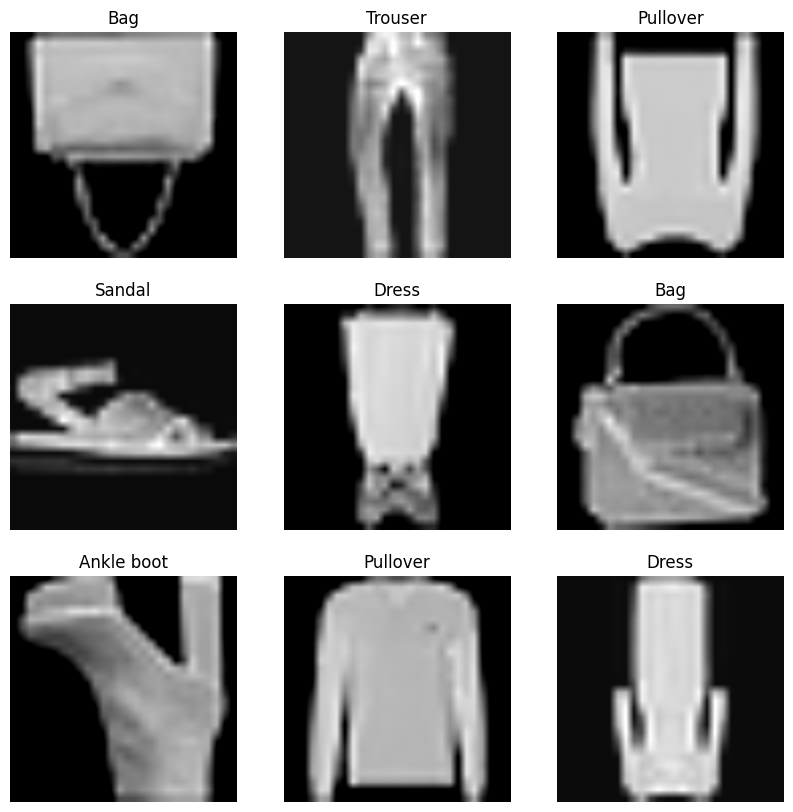

In [29]:
# %%
# Augmented data pipeline
def preprocess(image, label):
    image = tf.expand_dims(image, -1)  # (28, 28, 1)
    image = tf.image.resize(image, [224, 224])  # (224, 224, 1)
    image = tf.image.grayscale_to_rgb(image)  # (224, 224, 3)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def augment(image, label):
    # Data augmentation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

# Create dataset with augmentation
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(1000) \
    .batch(32) \
    .prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(32) \
    .prefetch(tf.data.AUTOTUNE)

# %%
# Visualize preprocessed images
sample_images, sample_labels = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    plt.title(class_names[sample_labels[i].numpy()])
    plt.axis('off')
plt.show()

## 4. Model Building with ResNet50

In [30]:
class ResNetFeatureExtractor(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.config = ResNetConfig.from_pretrained("microsoft/resnet-50")
        self._base_model_initialized = False

    def build(self, input_shape):
        if not self._base_model_initialized:
            self.base_model = TFResNetModel.from_pretrained("microsoft/resnet-50", config=self.config)
            self.base_model.trainable = False
            self._base_model_initialized = True
        super().build(input_shape)

    def call(self, inputs):
        x = tf.transpose(inputs, [0, 3, 1, 2])  # (batch, 3, 224, 224)
        outputs = self.base_model(pixel_values=x, training=False)
        return tf.reshape(outputs.last_hidden_state, [-1, 7, 7, 2048])

def create_custom_layer_model():
    inputs = Input(shape=(224, 224, 3))
    x = ResNetFeatureExtractor()(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# 3. Training with the custom layer model (better approach)
model = create_custom_layer_model()
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFResNetModel: ['resnet.encoder.stages.1.layers.3.layer.2.convolution.weight', 'resnet.encoder.stages.2.layers.4.layer.2.normalization.num_batches_tracked', 'resnet.encoder.stages.0.layers.0.layer.2.normalization.moving_variance', 'resnet.encoder.stages.3.layers.2.layer.0.normalization.moving_mean', 'resnet.encoder.stages.2.layers.5.layer.1.normalization.moving_mean', 'resnet.encoder.stages.3.layers.0.layer.1.normalization.weight', 'resnet.encoder.stages.0.layers.1.layer.1.normalization.bias', 'resnet.encoder.stages.2.layers.2.layer.0.normalization.bias', 'resnet.encoder.stages.0.layers.1.layer.1.normalization.num_batches_tracked', 'resnet.encoder.stages.3.layers.2.layer.2.normalization.bias', 'resnet.encoder.stages.0.layers.1.layer.2.normalization.weight', 'resnet.encoder.stages.2.layers.5.layer.2.convolution.weight', 'resnet.encoder.stages.0.layers.1.layer.2.convolution.weight', 'resnet.encoder.stages.

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 res_net_feature_extractor_2  (None, 7, 7, 2048)       23561152  
  (ResNetFeatureExtractor)                                       
                                                                 
 global_average_pooling2d_12  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 128)               262272    
                                                                 
 dense_15 (Dense)            (None, 10)                1290      
                                                                 
Total params: 23,824,714
Trainable params: 263,562
Non-trai

## 5. Model Training

In [31]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2)
    ]
)

1875/1875 [==============================] - 217s 114ms/step - loss: 1.8368 - accuracy: 0.3172 - val_loss: 1.4759 - val_accuracy: 0.4386 - lr: 0.0010


## 6. Model Evaluation

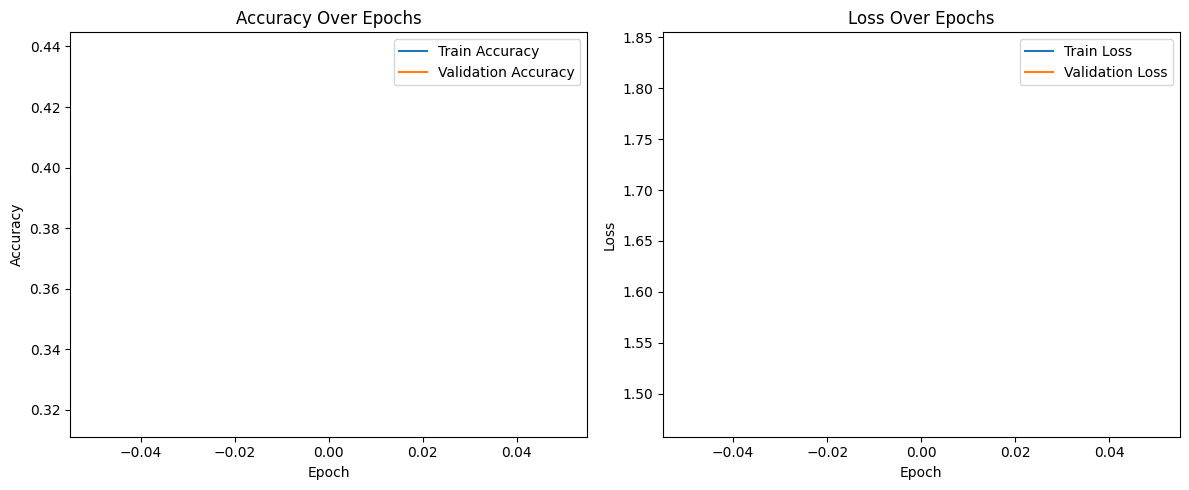

In [32]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

313/313 [==============================] - 29s 91ms/step - loss: 1.4759 - accuracy: 0.4386

Test Accuracy: 0.4386
Test Loss: 1.4759
313/313 [==============================] - 29s 89ms/step


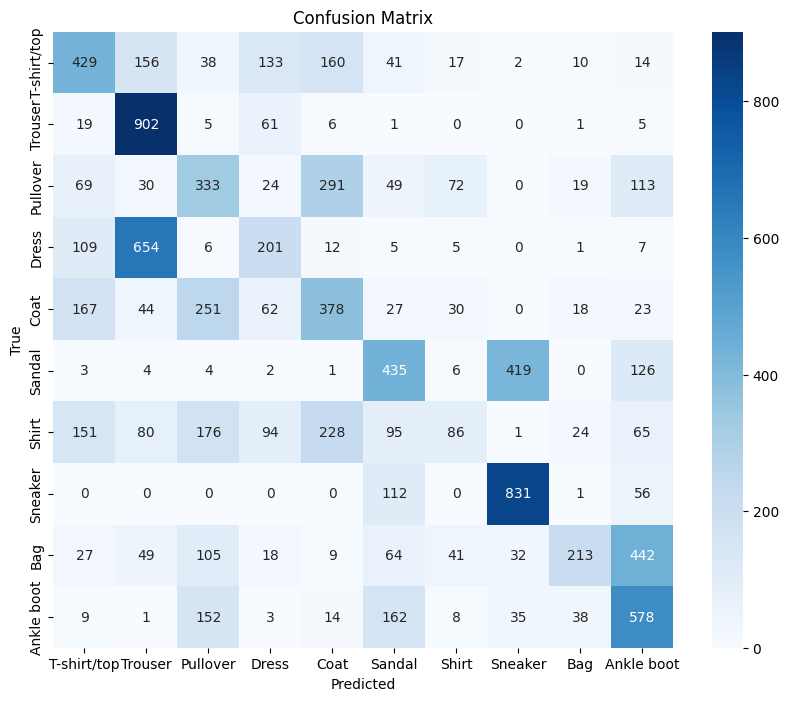


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.44      0.43      0.43      1000
     Trouser       0.47      0.90      0.62      1000
    Pullover       0.31      0.33      0.32      1000
       Dress       0.34      0.20      0.25      1000
        Coat       0.34      0.38      0.36      1000
      Sandal       0.44      0.43      0.44      1000
       Shirt       0.32      0.09      0.14      1000
     Sneaker       0.63      0.83      0.72      1000
         Bag       0.66      0.21      0.32      1000
  Ankle boot       0.40      0.58      0.48      1000

    accuracy                           0.44     10000
   macro avg       0.44      0.44      0.41     10000
weighted avg       0.44      0.44      0.41     10000



In [33]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# %%
# Generate predictions
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# %%
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))


## 7. Save test iamges locally to upload on flask app

In [34]:

import os
import numpy as np
from PIL import Image

# Load Fashion MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Take first 5 test images
sample_images = x_test[:5]
sample_labels = y_test[:5]

# Create directory to save images
output_dir = 'fashion_mnist_samples'
os.makedirs(output_dir, exist_ok=True)

# Class names for labeling
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Save each image with its label
for i, (img, label) in enumerate(zip(sample_images, sample_labels)):
    # Convert numpy array to PIL Image
    img_pil = Image.fromarray(img)
    
    # Create filename with class name
    filename = f"{i}_{class_names[label]}.png"
    filepath = os.path.join(output_dir, filename)
    
    # Save image
    img_pil.save(filepath)
    print(f"Saved: {filepath}")

print(f"\nAll {len(sample_images)} sample images saved to '{output_dir}' directory")

Saved: fashion_mnist_samples\0_Ankle boot.png
Saved: fashion_mnist_samples\1_Pullover.png
Saved: fashion_mnist_samples\2_Trouser.png
Saved: fashion_mnist_samples\3_Trouser.png
Saved: fashion_mnist_samples\4_Shirt.png

All 5 sample images saved to 'fashion_mnist_samples' directory


## 7. Save Model and Create Flask App

In [35]:
import os
import json
from tensorflow.keras.models import save_model

# Define the path to the artifacts folder (outside current notebook directory)
artifacts_dir = os.path.join("..", "artifacts")  # Goes up one level from the notebook
os.makedirs(artifacts_dir, exist_ok=True)

# Save the model
model_path = os.path.join(artifacts_dir, "fashion_mnist_resnet50.h5")
model.save(model_path, save_format="h5")  # Saves in HDF5 format

# Save class names
class_names_path = os.path.join(artifacts_dir, "class_names.json")
with open(class_names_path, 'w') as f:
    json.dump(class_names, f)

print(f"Model saved to: {model_path}")
print(f"Class names saved to: {class_names_path}")

Model saved to: ..\artifacts\fashion_mnist_resnet50.h5
Class names saved to: ..\artifacts\class_names.json
